In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.util import metrics

In [2]:
# sns.set(rc={'figure.figsize':(15,8)})
df = pd.read_csv('monthly1971-2020.csv',parse_dates=['Month'])
df

,Month,Arrivals,Monthly_covid_cases,Terrorist_Attack_death
0,1971-01-01,5931,0,0
1,1971-02-01,6570,0,0
2,1971-03-01,5166,0,0
3,1971-04-01,1539,0,0
4,1971-05-01,952,0,0
...,...,...,...,...
616,2022-05-01,30207,0,0
617,2022-06-01,32856,0,0
618,2022-07-01,47290,0,0
619,2022-08-01,37760,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   621 non-null    datetime64[ns]
 1   Arrivals                621 non-null    int64         
 2   Monthly_covid_cases     621 non-null    int64         
 3   Terrorist_Attack_death  621 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 19.5 KB


Text(0.5, 1.0, 'Total Arrivals')

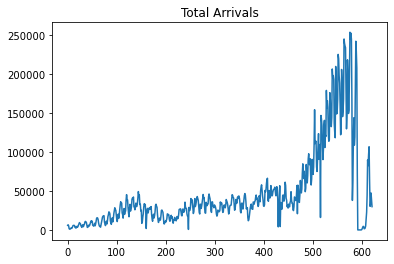

In [17]:
df['Arrivals'].plot()
plt.title("Total Arrivals")
fig,ax=plt.subplots(figsize=(15,5))
arrivals_df.plot(ax=ax)

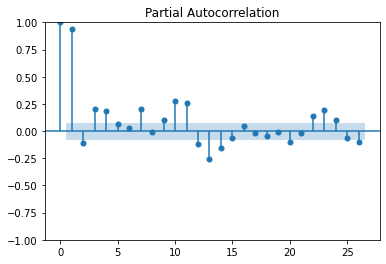

In [5]:
f = Forecaster(y=df['Arrivals'],current_dates=df['Month'])
transformer = SeriesTransformer(f)
f.plot_pacf(lags=26)
plt.show()

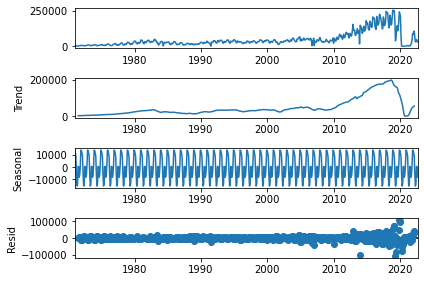

In [6]:
f.seasonal_decompose().plot()
plt.show()

In [7]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(f"stat: {stat}, P-val: {pval}")

stat: -2.3373590484415367, P-val: 0.160201796937591


In [8]:
#pvalue not less than 0.05. Hence data  is non-stationary

In [9]:
f = transformer.DiffTransform(12)

In [10]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(f"stat: {stat}, P-val: {pval}")

stat: -5.996792177065337, P-val: 1.694094673043943e-07


In [11]:
# P values is almost 0. Hence data is now stationary

[13:12:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lags" } are not used.

[13:12:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lags" } are not used.



<AxesSubplot:xlabel='Date', ylabel='Values'>

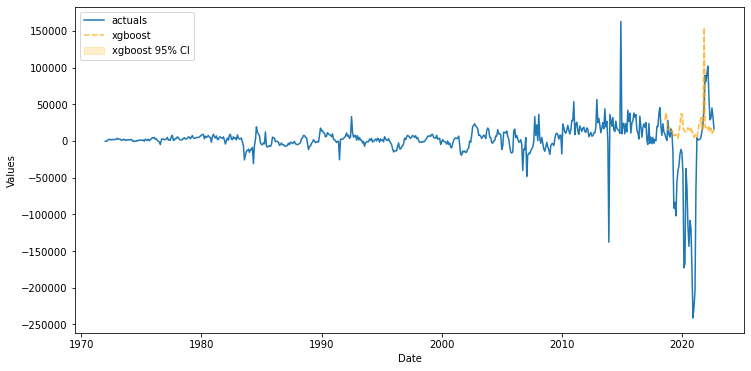

In [12]:
f.set_test_length(50)
f.generate_future_dates(50)
f.add_time_trend()
f.add_seasonal_regressors('month',raw=False,sincos=True)
f.add_ar_terms(13)


f.set_estimator('xgboost')
f.manual_forecast(gamma=1,dynamic_testing=13,lags=13)
f.plot_test_set(ci=True)

In [13]:
fitted_vals=f.export_fitted_vals('xgboost',False)

In [14]:
fitted_vals

,DATE,Actuals,FittedVals,Residuals
0,1973-02-01,2495.0,2534.119873,-39.119873
1,1973-03-01,2311.0,2251.846680,59.153320
2,1973-04-01,2374.0,2415.385742,-41.385742
3,1973-05-01,886.0,991.756836,-105.756836
4,1973-06-01,944.0,1000.112732,-56.112732
...,...,...,...,...
591,2022-05-01,28710.0,28758.537109,-48.537109
592,2022-06-01,31242.0,31254.779297,-12.779297
593,2022-07-01,44861.0,44874.769531,-13.769531
594,2022-08-01,32720.0,32741.341797,-21.341797


In [15]:
def compute_error_metrics(model_nick_name,df):
    mae=metrics.mae(df['Actuals'],df['FittedVals'])
    rmse=metrics.rmse(df['Actuals'],df['FittedVals'])
    mse=metrics.mse(df['Actuals'],df['FittedVals'])
    
    print(f"mean absolute error for {model_nick_name}: {mae}")
    print(f"root mean squared error for {model_nick_name}: {rmse}")
    print(f"mean squared error for {model_nick_name}: {mse}")

    return mae, rmse, mse

In [16]:
mae,rmse,mse=compute_error_metrics('xgboost',fitted_vals)

mean absolute error for xgboost: 68.44096927034775
root mean squared error for xgboost: 97.96444195647159
mean squared error for xgboost: 9597.031887842892


<AxesSubplot:xlabel='Date', ylabel='Values'>

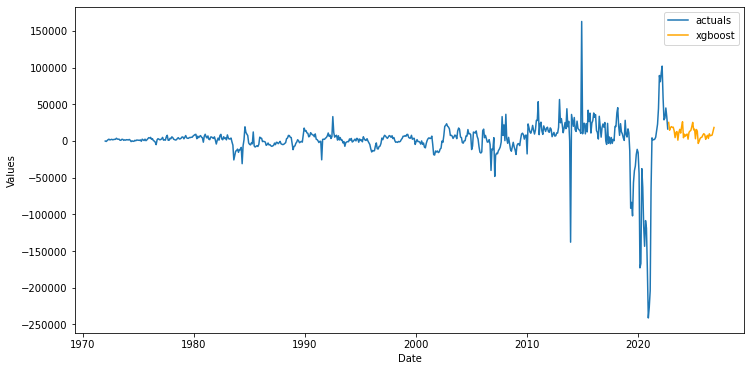

In [19]:
f.plot(models=['xgboost'],
       order_by='LevelTestSetMAE',
       level=True)

In [20]:
f.export('model_summaries',determine_best_by='LevelTestSetR2')[
    ['ModelNickname',
     'LevelTestSetRMSE',
     'LevelTestSetR2',
     'best_model']
]

,ModelNickname,LevelTestSetRMSE,LevelTestSetR2,best_model
0,xgboost,94741.867315,-0.320111,True
